# Wasserstein GAN with Gradient Penalty
## For generation of a 1D gaussian distribution

In [27]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

tf.random.set_seed(0xDEADBEEF)

2.0.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [28]:
# Network hyperparameters
BATCH_SIZE = 512
EPOCHS = 1000

# Adam hyperparameters as recommended by arXiv:1704.00028
LEARNING_RATE_GEN = 1e-4
LEARNING_RATE_DISC = 1e-4
BETA_1 = 0
BETA_2 = 0.9

# WGAN hyperparameters
N_CRITIC = 5
C_LAMBDA = 10

In [29]:
gaussian = np.random.normal(loc=0,scale=1,size=(BATCH_SIZE * 4 * 100,1)).astype("float32")

In [30]:
# Normalize all inputs between -1 and 1

scaler = MinMaxScaler((-1,1)).fit(gaussian)
feature_df = scaler.transform(gaussian)

X_train, X_test = train_test_split(feature_df, test_size = 0.25, random_state = 1234)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [32]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(1,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation='tanh'))
    assert model.output_shape == (None, 1)

    return model

In [33]:
generator = make_generator_model()

In [34]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(1,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [35]:
discriminator = make_discriminator_model()

In [36]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                100       
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 351
Trainable params: 251
Non-trainable params: 100
_________________________________________________________________


In [37]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [38]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [39]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [40]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [41]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_GEN, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_DISC, beta_1=BETA_1, beta_2=BETA_2)

In [42]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [43]:
@tf.function
def train_step_generator():
  noise = tf.random.normal([BATCH_SIZE, 1])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [44]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, 1])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,1])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [45]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, 1])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [46]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, 1])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE, 1])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [47]:
def graph_gan(generator):
    realdata = scaler.inverse_transform(X_train)
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, 1)), training=False))
    plt.title("Gaussian")
    plt.ylabel("Normalized to Unity")
    plt.xlabel("$x$")
    plt.hist(realdata[:,0], bins = 25, range = (-10, 10), color = "tab:orange", alpha = 0.5, label = "Gaussian", density = True)
    plt.hist(fakedata[:,0], bins = 25, range = (-10, 10), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [48]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [49]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [50]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [51]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = False # ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 10 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for batchnum, image_batch in enumerate(dataset):
      if random.random() < 1 / n_critic:
        train_gen_loss += K_eval(train_step_generator()) * n_critic / len_dataset
      train_disc_loss += K_eval(train_step_discriminator(image_batch)) / len_dataset
    
    train_gen_losses.append(train_gen_loss)
    train_disc_losses.append(train_disc_loss)

    # Evaluation

    for batchnum, test_batch in enumerate(testset):
      test_gen_loss += K_eval(evaluate_generator()) / len_testset
      test_disc_loss += K_eval(evaluate_discriminator(test_batch)) / len_testset

    test_gen_losses.append(test_gen_loss)
    test_disc_losses.append(test_disc_loss)

    # Logging

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)
      graph_genloss()
      graph_discloss()

  1%|          | 9/1000 [00:12<20:56,  1.27s/it]
Epoch 10:


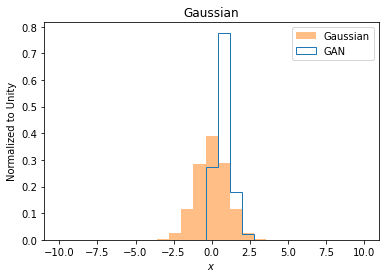

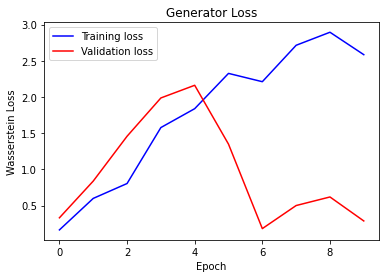

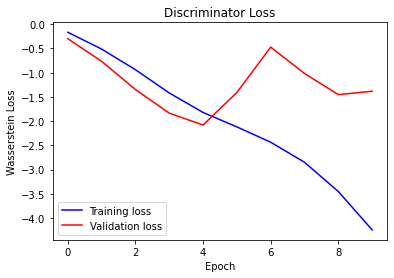

  2%|▏         | 19/1000 [00:24<18:21,  1.12s/it]
Epoch 20:


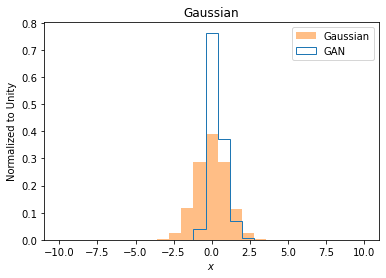

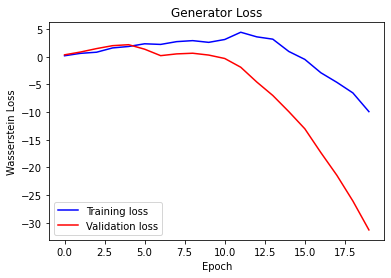

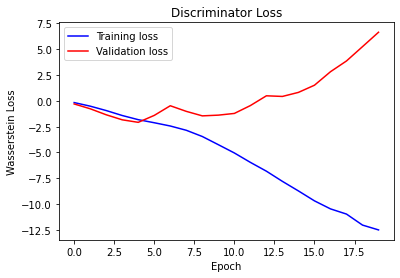

  3%|▎         | 29/1000 [00:37<19:37,  1.21s/it]
Epoch 30:


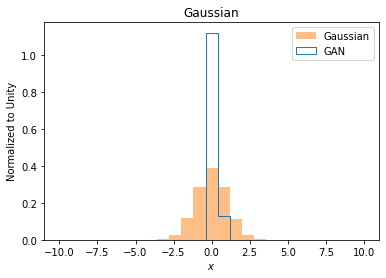

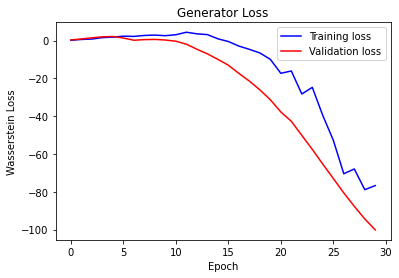

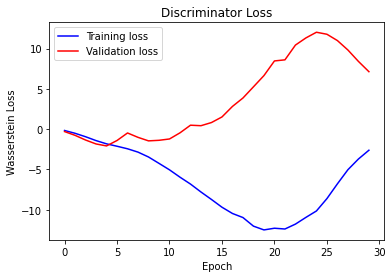

  4%|▍         | 39/1000 [00:50<18:23,  1.15s/it]
Epoch 40:


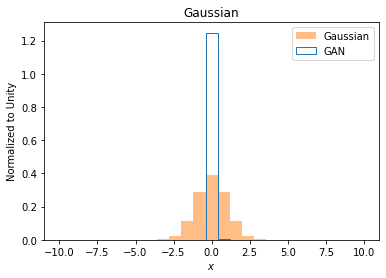

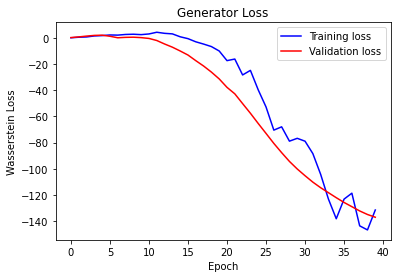

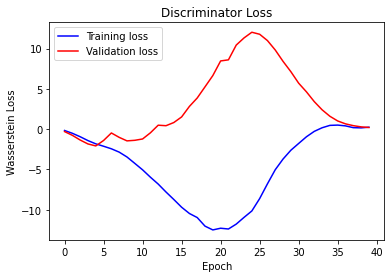

  4%|▍         | 43/1000 [00:57<21:13,  1.33s/it]


KeyboardInterrupt: 

In [52]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)

In [27]:
scaler.inverse_transform(generator(tf.random.normal((10000, 1)), training=False))

array([[4.49375432],
       [4.49188611],
       [4.49167203],
       ...,
       [4.49112858],
       [4.49399716],
       [4.49447369]])

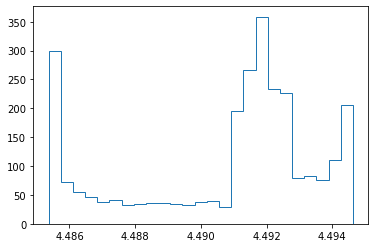

In [28]:
fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, 1)), training=False))
plt.hist(fakedata[:,0], bins = 25, color = "tab:blue", histtype = "step", label = "GAN", density = True)
plt.show()